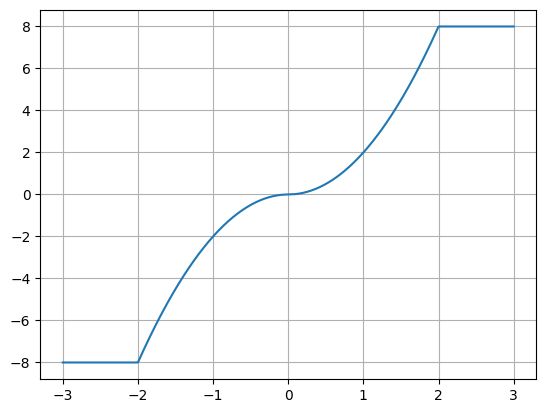

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-3, 3, 1000)

def BiPolarSquaredClip(x):
    y =  np.where(x > 0, 2*np.square(x), -2 * np.square(x))
    y_clipped = np.clip(y, -8, 8)
    return y_clipped

plt.plot(x,BiPolarSquaredClip(x))
plt.grid()
plt.show()

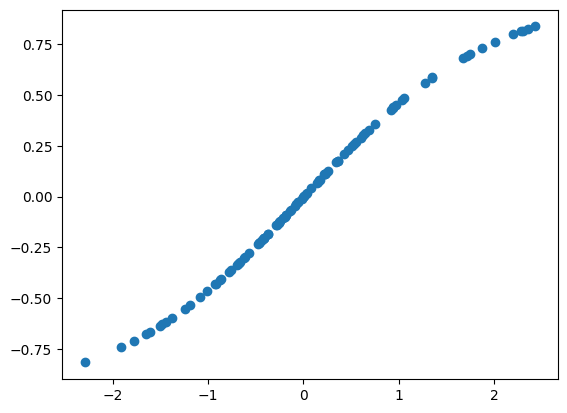

In [58]:
import torch
import torch.nn as nn



#

class SoftModulusQ(nn.Module):
    def __init__(self):
        super(SoftModulusQ, self).__init__()
    
    def forward(self, x):
        return torch.where(torch.abs(x) <= 1, x**2 * (2 - torch.abs(x)), torch.abs(x))


# Vallés-Pérez et al. (2023)
class Modulus(nn.Module):
    def __init__(self):
        super(Modulus, self).__init__()
    
    def forward(self, x):
        return torch.abs(x)

class BipolarSigmoid(nn.Module):
    def __init__(self):
        super(BipolarSigmoid, self).__init__()
    
    def forward(self, x):
        return 2 * (1 / (1 + torch.exp(-x))) - 1
    
#
class TanhExp(nn.Module):
    def __init__(self):
        super(TanhExp, self).__init__()
    
    def forward(self, x):
        return x * torch.tanh(torch.exp(x))
    
# My method
class BipolarClippedActivation(nn.Module):
    def __init__(self, pos_multiplier=2, neg_multiplier=-2, clip_min=-8, clip_max=8):
        super(BipolarClippedActivation, self).__init__()
        self.pos_multiplier = pos_multiplier
        self.neg_multiplier = neg_multiplier
        self.clip_min = clip_min
        self.clip_max = clip_max

    def forward(self, x):
        # 조건에 따라 값을 계산
        y = torch.where(x > 0, self.pos_multiplier * torch.square(x),
                        self.neg_multiplier * torch.square(x))
        # 결과값 클리핑
        y_clipped = torch.clamp(y, self.clip_min, self.clip_max)
        return y_clipped

act = BipolarSigmoid()
x = torch.linspace(-3,3,50)
x = torch.randn((100,))
plt.scatter(x.numpy(),act(x).numpy())


In [50]:
def vis_activations(activations, x, cols):
    """
    activations: 활성화 함수 객체의 리스트
    x: 입력 텐서
    cols: 하나의 행에 표시될 그래프의 수
    """
    # 전체 활성화 함수의 수
    total = len(activations)
    # 계산된 행 수
    rows = total // cols + (1 if total % cols else 0)
    
    plt.figure(figsize=(cols * 5, rows * 4))
    
    for i, activation in enumerate(activations, 1):
        y = activation(x)
        plt.subplot(rows, cols, i)
        plt.scatter(x.numpy(), y.detach().numpy())
        plt.title(activation.__class__.__name__)
    
    plt.tight_layout()
    plt.show()


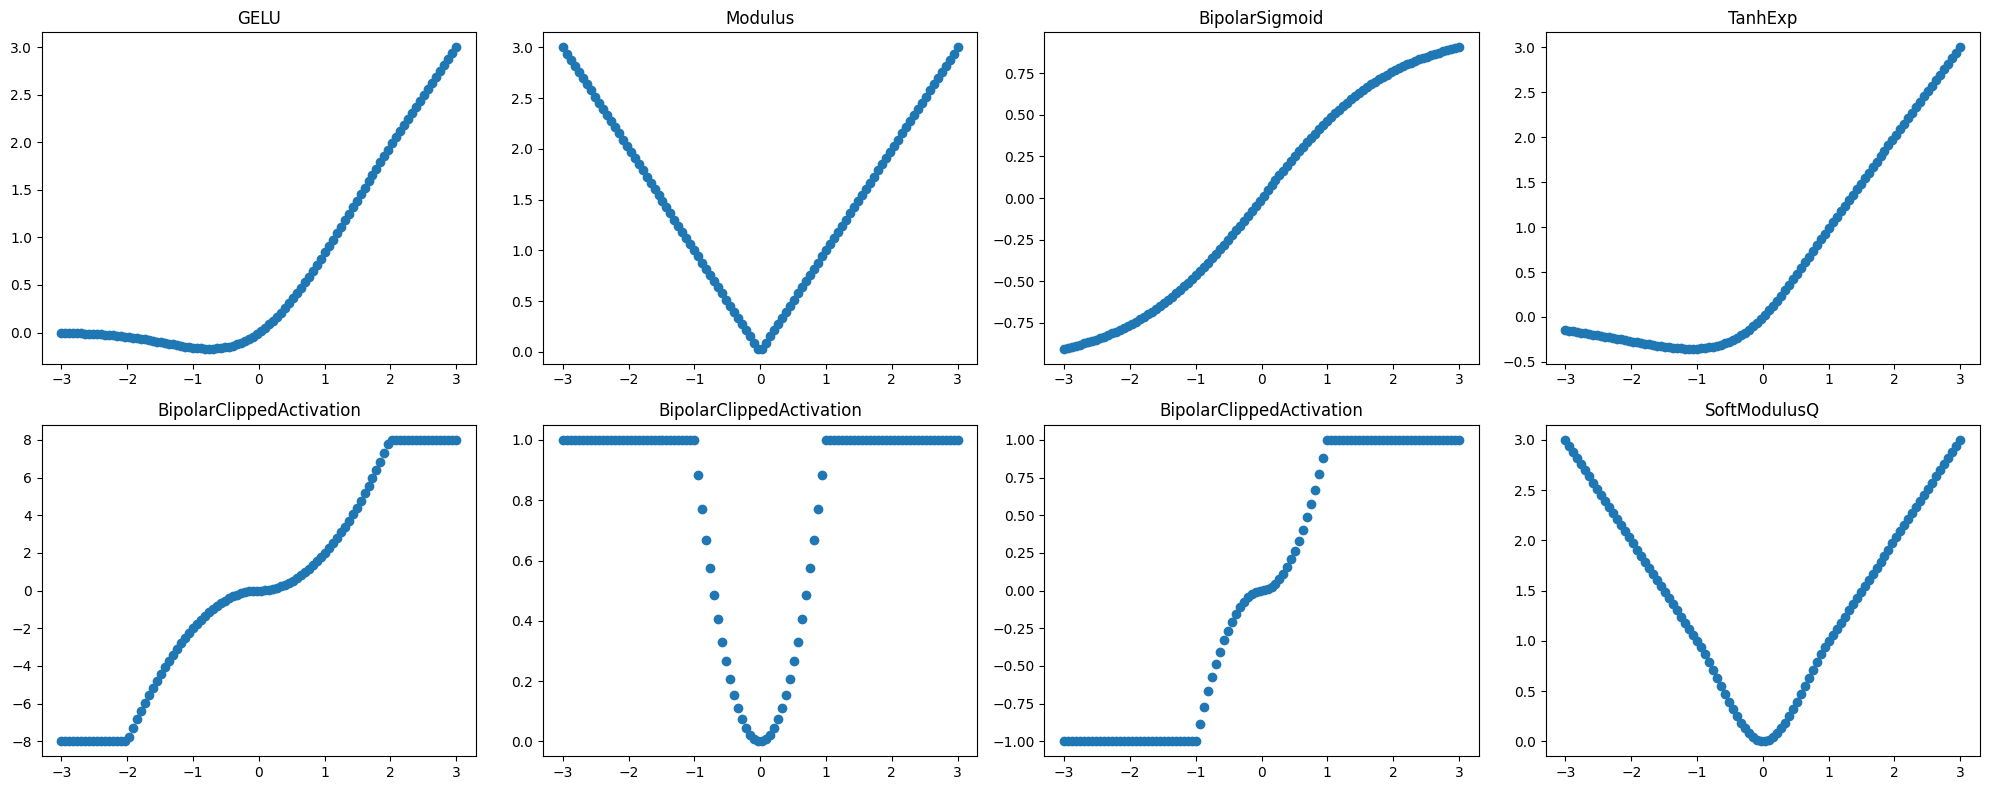

In [60]:
# 활성화 함수 인스턴스 생성
gelu = nn.GELU()
modulus = Modulus()
bipolar_sigmoid = BipolarSigmoid()
tanh_exp = TanhExp()
softmodulus = SoftModulusQ()
bipolar_clipped_activation = BipolarClippedActivation()
bipolar_clipped_activation_curr_best = BipolarClippedActivation(clip_max=1,clip_min=-1,pos_multiplier=1,neg_multiplier=1)
bipolar_clipped_activation_target_best = BipolarClippedActivation(clip_max=1,clip_min=-1,pos_multiplier=1,neg_multiplier=-1)


# 활성화 함수 리스트
activations = [gelu,modulus, bipolar_sigmoid, tanh_exp, bipolar_clipped_activation,bipolar_clipped_activation_curr_best,bipolar_clipped_activation_target_best,softmodulus]

# 입력 데이터
x = torch.linspace(-3, 3, 100)

# 시각화 함수 호출
vis_activations(activations, x, cols=4)


Activation function Test


In [32]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
 
# Load the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)
 
train_loader = DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2048, shuffle=False)

In [33]:
import torch.nn as nn
import torch.optim as optim

 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_function):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        self.activation_function = activation_function
 
    def forward(self, x):
        x = self.activation_function(self.layer1(x))
        x = self.activation_function(self.layer2(x))
        x = self.layer3(x)
        return x

In [34]:
def train(network, data_loader, criterion, optimizer, device):
    network.train()
    running_loss = 0.0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.shape[0], -1)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    return running_loss / len(data_loader.dataset)

def test(network, data_loader, criterion, device):
    network.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)

            output = network(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return test_loss / len(data_loader.dataset), 100 * correct / total

In [61]:
from time import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_size = 784
hidden_size = 128
num_classes = 10
num_epochs = 20
learning_rate = 0.001

activation_functions = {
    # 'ReLU': nn.ReLU(),
    # 'Sigmoid': nn.Sigmoid(),
    # 'Tanh': nn.Tanh(),
    # 'LeakyReLU': nn.LeakyReLU(),
    # 'GELU':nn.GELU(),
    # 'Modulus':Modulus(),
    # 'BipolarSigmoid':BipolarSigmoid(),
    # 'TanhExp':TanhExp(),
    'SoftModulusQ':SoftModulusQ(),
    'BiPolarSquaredClip_mul_m1_clip_1':BipolarClippedActivation(clip_max=1,clip_min=-1,pos_multiplier=1,neg_multiplier=-1),
    'BiPolarSquaredClip_base':BipolarClippedActivation(),
    'BiPolarSquaredClip_mul_m1_clip_4':BipolarClippedActivation(clip_max=4,clip_min=-4,pos_multiplier=1,neg_multiplier=-1),
    'BiPolarSquaredClip_mul_1_clip_1':BipolarClippedActivation(clip_max=1,clip_min=-1,pos_multiplier=1,neg_multiplier=1),
    


}

results = {}

# Train and test the model with different activation functions
for name, activation_function in activation_functions.items():
    print(f"Training with {name} activation function...")

    model = NeuralNetwork(input_size, hidden_size, num_classes, activation_function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    start_t = time()
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, test_loader, criterion, device)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    end_t = time() - start_t
    minutes = int(end_t // 60)
    seconds = int(end_t % 60)

    results[name] = {
        'train_loss_history': train_loss_history,
        'test_loss_history': test_loss_history,
        'test_accuracy_history': test_accuracy_history,
        'train_test_time':f"{minutes}m{seconds}s"
    }

cuda
Training with SoftModulusQ activation function...
Epoch [1/20], Test Loss: 0.5371, Test Accuracy: 86.13%
Epoch [2/20], Test Loss: 0.2930, Test Accuracy: 91.54%
Epoch [3/20], Test Loss: 0.2252, Test Accuracy: 93.36%
Epoch [4/20], Test Loss: 0.1834, Test Accuracy: 94.57%
Epoch [5/20], Test Loss: 0.1579, Test Accuracy: 95.28%
Epoch [6/20], Test Loss: 0.1377, Test Accuracy: 95.83%
Epoch [7/20], Test Loss: 0.1228, Test Accuracy: 96.22%
Epoch [8/20], Test Loss: 0.1113, Test Accuracy: 96.74%
Epoch [9/20], Test Loss: 0.1034, Test Accuracy: 96.86%
Epoch [10/20], Test Loss: 0.0988, Test Accuracy: 97.02%
Epoch [11/20], Test Loss: 0.0946, Test Accuracy: 97.05%
Epoch [12/20], Test Loss: 0.0888, Test Accuracy: 97.23%
Epoch [13/20], Test Loss: 0.0861, Test Accuracy: 97.34%
Epoch [14/20], Test Loss: 0.0816, Test Accuracy: 97.39%
Epoch [15/20], Test Loss: 0.0784, Test Accuracy: 97.65%
Epoch [16/20], Test Loss: 0.0763, Test Accuracy: 97.58%
Epoch [17/20], Test Loss: 0.0763, Test Accuracy: 97.60%
Ep

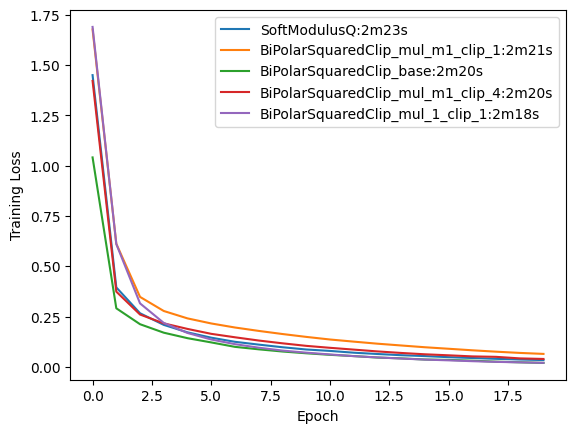

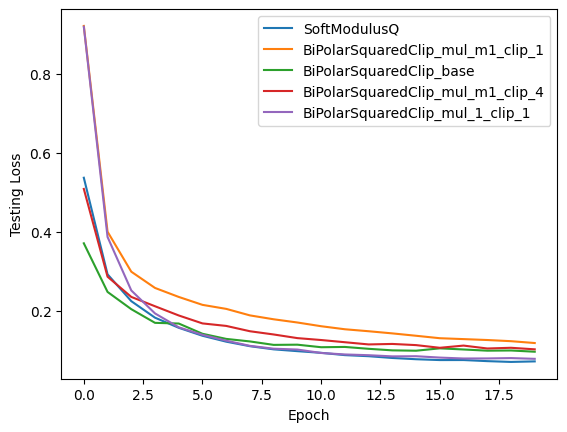

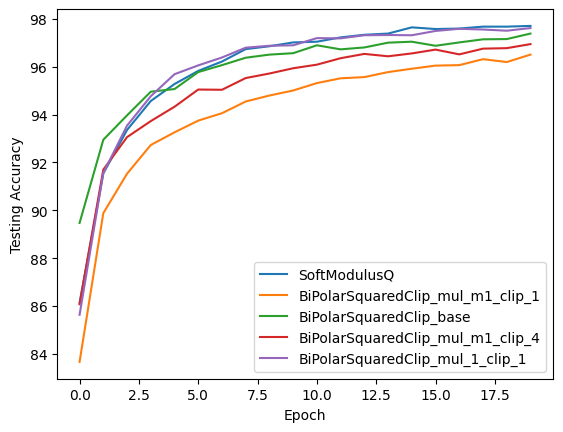

In [62]:
import matplotlib.pyplot as plt
 
# Plot the training loss
plt.figure()
for name, data in results.items():
    plt.plot(data['train_loss_history'], label=f"{name}:{data['train_test_time']}")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig(f'./Activation/train_loss_{"_".join(results.keys())}.png')
plt.show()
 
# Plot the testing loss
plt.figure()
for name, data in results.items():
    plt.plot(data['test_loss_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.savefig(f'./Activation/test_loss_{"_".join(results.keys())}.png')
plt.show()
 
# Plot the testing accuracy
plt.figure()
for name, data in results.items():
    plt.plot(data['test_accuracy_history'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.savefig(f'./Activation/test_acc_{"_".join(results.keys())}.png')
plt.show()

'ReLU_Sigmoid_Tanh_LeakyReLU_BiPolarSquaredClip'